In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transforms import Rescale, RandomCrop, RandomHorizontalFlip, ToTensor
from dataset import FaceLandmarksDataset
from torchvision.transforms import Compose
from utils import train_net
from pathlib import Path

In [2]:
LANDMARKS_FRAME_PATH = 'data/list_landmarks_align_celeba.csv'
IMG_FOLDER_PATH = 'data/img_align_celeba/img_align_celeba'
WEIGHTS_PATH = 'weights/resnet18.pth'
# TRAIN_IDX = (0, 162770)
TRAIN_IDX = (0, 200)
# VAL_IDX = (162770, 182637)
VAL_IDX = (162770, 162970)
# TEST_IDX = (182637, 202599)
TEST_IDX = (182637, 182837)
N_TARGETS = 10

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
transform = Compose(
    [
     Rescale((224, 224)),
     ToTensor(),
    ]
)

transform_augment = Compose(
    [
     Rescale((256, 256)),
     RandomCrop(224),
     RandomHorizontalFlip(),
     ToTensor(),
    ]
)

In [5]:
trainset = FaceLandmarksDataset(LANDMARKS_FRAME_PATH, IMG_FOLDER_PATH, transform_augment, TRAIN_IDX)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=8)

In [6]:
valset = FaceLandmarksDataset(LANDMARKS_FRAME_PATH, IMG_FOLDER_PATH, transform, VAL_IDX)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=8)

In [7]:
net = torchvision.models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=512, out_features=N_TARGETS, bias=True)
net = net.double()

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=0.001)

[1,    50] train_loss: 14388.361, val_loss: 13444.618
[2,    50] train_loss: 12068.940, val_loss: 11003.299
[3,    50] train_loss: 9675.384, val_loss: 8510.231
[4,    50] train_loss: 7578.339, val_loss: 6453.774
[5,    50] train_loss: 5776.222, val_loss: 4451.025
[6,    50] train_loss: 4309.752, val_loss: 3824.105
[7,    50] train_loss: 3120.687, val_loss: 2550.840
[8,    50] train_loss: 2207.872, val_loss: 1460.696
[9,    50] train_loss: 1546.898, val_loss: 747.411
[10,    50] train_loss: 1084.568, val_loss: 701.983
[11,    50] train_loss: 757.760, val_loss: 531.980
[12,    50] train_loss: 543.816, val_loss: 405.589
[13,    50] train_loss: 418.999, val_loss: 73.031
[14,    50] train_loss: 334.299, val_loss: 101.128
[15,    50] train_loss: 280.896, val_loss: 118.642
[16,    50] train_loss: 243.851, val_loss: 191.922
[17,    50] train_loss: 236.617, val_loss: 167.223
[18,    50] train_loss: 218.490, val_loss: 168.984
[19,    50] train_loss: 203.062, val_loss: 118.374
[20,    50] train_l

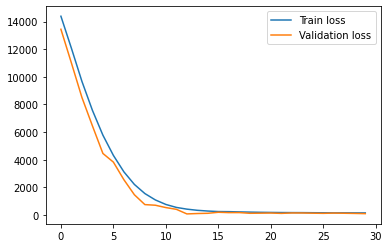

In [9]:
train_net(net, trainloader, valloader, criterion, optimizer, device, 
          num_epochs=30, lr_scheduler=scheduler, eval_period=len(trainloader))

In [10]:
Path('weights').mkdir(exist_ok=True)
torch.save(net.state_dict(), WEIGHTS_PATH)

## Evaluating

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
net = torchvision.models.resnet18()
net.fc = nn.Linear(in_features=512, out_features=N_TARGETS, bias=True)
net = net.double()

In [13]:
net.load_state_dict(torch.load(WEIGHTS_PATH))
net.to(device)
net = net.eval()

In [14]:
testset = FaceLandmarksDataset(LANDMARKS_FRAME_PATH, IMG_FOLDER_PATH, transform, TEST_IDX)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=8)

In [15]:
test_loss = 0
criterion = nn.MSELoss()
with torch.no_grad():
    for data in testloader:
        images, labels = data['image'].to(device), data['landmarks'].to(device)
        labels = labels.reshape(labels.shape[0], -1)
        outputs = net(images)
        test_loss += criterion(outputs, labels)

print('MSE of the network on test images: %f' % (test_loss / len(testloader)))
print('RMSE of the network on test images: %f' % (np.sqrt(test_loss / len(testloader))))

MSE of the network on test images: 103.442479
RMSE of the network on test images: 10.170668
